# **EARTHQUAKE DAMAGE PREDICTION**

https://www.drivendata.org/competitions/57/nepal-earthquake/page/136/

* Andrea Morales Garzón `andreamgmg@correo.ugr.es`
* Ithiel Piñero Darias `ithiel@correo.ugr.es`
* Paula Villa Martín `pvilla@correo.ugr.es`
* Antonio Manjavacas Lucas `manjavacas@correo.ugr.es`

Basándonos en factores relacionados con la localización de los edificios y su construcción, el objetivo de este trabajo será predecir el nivel de daño provocado por el terremoto Gorkha de 2015 sobre edificios en Nepal.

Los datos fueron recopilados por medio de encuestas realizadas por Kathmandu Living Labs y la Oficina Central de Estadística, dependiente de la Comisión Nacional de Planificación de la Secretaría de Nepal. Esta encuesta es uno de los mayores conjuntos de datos posteriores a un desastre jamás reunidos, y 
contiene información valiosa sobre los efectos de los terremotos, las condiciones de los hogares y estadísticas socioeconómicas y demográficas.

Trataremos de predecir la variable ordinal `damage_grade`, que representa el nivel de daño provocado sobre los edificios afectados por el terremoto:

* `damage_grade` = 1 representa un daño bajo;
* `damage_grade` = 2 representa un daño medio;
* `damage_grade` = 3 representa una destrucción del edificio casi completa.


In [ ]:
install.packages('tidyverse')
install.packages('NoiseFiltersR')
install.packages('caret')
install.packages('RWeka')
install.packages('MLmetrics')
install.packages('UBL')
install.packages('mltools')
install.packages('data.table')
install.packages('nortest')

In [ ]:
set.seed(42)

library(tidyverse)
library(NoiseFiltersR)
library(caret)
library(RWeka)
library(MLmetrics)
library(UBL)
library(mltools)
library(data.table)
library(nortest)

Carga de datos:

In [3]:
TRAIN_VALUES_ID = '15ykpkKIJNKlEXQQ3taspRjUZ2sJN5zS_'
TRAIN_LABELS_ID = '1nrNVfj9NmNvwPhXuucUBYhh-FmODCCBK'
TEST_VALUES_ID = '1_GpX1sh7XkJLm-kyOpcObzXICW5Z-tb_'

load_file <- function(id) {
  read_csv(sprintf('https://docs.google.com/uc?id=%s&export=download', id), col_types=cols())
}

train_values <- load_file(TRAIN_VALUES_ID)
train_labels <- load_file(TRAIN_LABELS_ID)
test_values <- load_file(TEST_VALUES_ID)

test_ids <- test_values$building_id

Conversión de las columnas con datos categóricos a factores:

In [4]:
cols_to_factor <- c(9:15, 27)

ids <- test_values$building_id

train_values[cols_to_factor] <- lapply(train_values[cols_to_factor], factor)
test_values[cols_to_factor] <- lapply(test_values[cols_to_factor], factor)

train_labels$damage_grade <- factor(train_labels$damage_grade)

# **Análisis exploratorio de datos**

In [5]:
data <- merge(x = train_values, y = train_labels, by = 'building_id')
head(data)

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,⋯,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,4,30,266,1224,1,25,5,2,t,r,⋯,0,0,0,0,0,0,0,0,0,2
2,8,17,409,12182,2,0,13,7,t,r,⋯,0,0,0,0,0,0,0,0,0,3
3,12,17,716,7056,2,5,12,6,o,r,⋯,0,0,0,0,0,0,0,0,0,3
4,16,4,651,105,2,80,5,4,n,r,⋯,0,0,0,0,0,0,0,0,0,2
5,17,3,1387,3909,5,40,5,10,t,r,⋯,0,0,0,0,0,0,0,0,0,2
6,25,26,1132,6645,2,0,6,6,t,w,⋯,0,0,0,0,0,0,0,0,0,1


## **Análisis gráfico**

Variables `has_superstructure`:

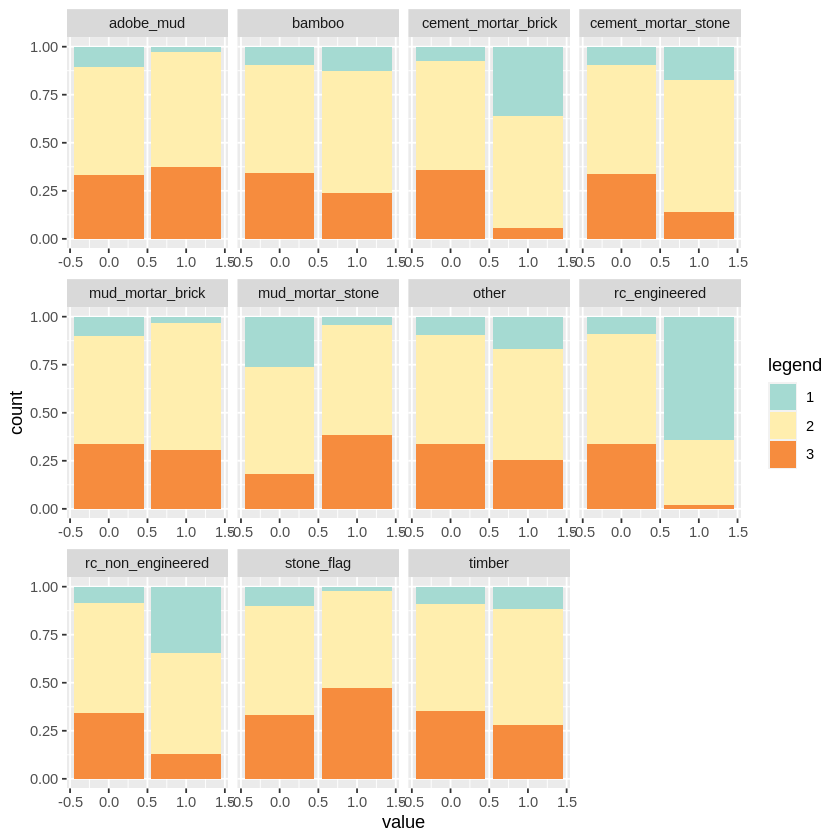

In [6]:
data_has_super <- data %>% dplyr::select(damage_grade, starts_with("has_superstructure"))
names(data_has_super) = gsub(pattern = "has_superstructure_", replacement = "", x = names(data_has_super))
gathered <- data_has_super %>% gather(variable, value, -damage_grade)
p <-  ggplot(gathered, aes(value, fill = factor(damage_grade))) + 
  geom_bar(position = "fill") + facet_wrap( ~ variable, scales = 'free_x') +
  scale_fill_manual("legend", values = c("1" = "#a5dad2", "2" = "#ffeeae", "3" = "#f68c3e"))
p

# ggsave(p, filename = "has_superstructure.png")

Variables `has_secondary`:

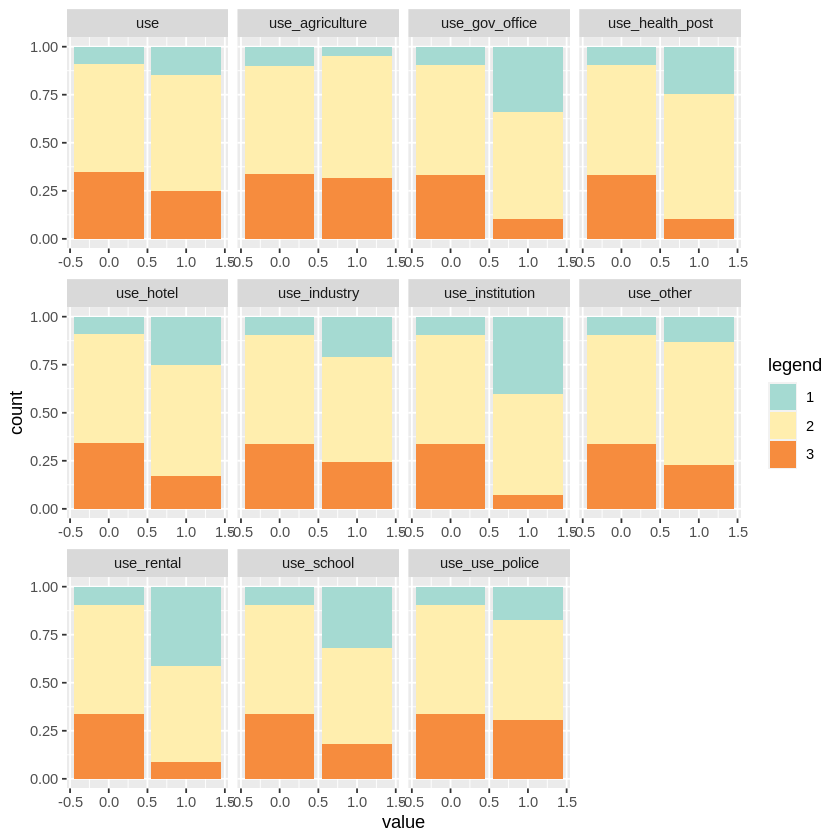

In [7]:
data_has_second <- data %>% dplyr::select(damage_grade, starts_with("has_secondary"))
names(data_has_second) = gsub(pattern = "has_secondary_", replacement = "", x = names(data_has_second))
gathered <- data_has_second %>% gather(variable, value, -damage_grade)
p <- ggplot(gathered, aes(value, fill = factor(damage_grade))) + 
  geom_bar(position = "fill") + facet_wrap( ~ variable, scales = 'free_x') +
  scale_fill_manual("legend", values = c("1" = "#a5dad2", "2" = "#ffeeae", "3" = "#f68c3e"))
p

# ggsave(p, filename = "has_secondary.png")

Variables con etiquetas:

Warning message:
“attributes are not identical across measure variables;
they will be dropped”


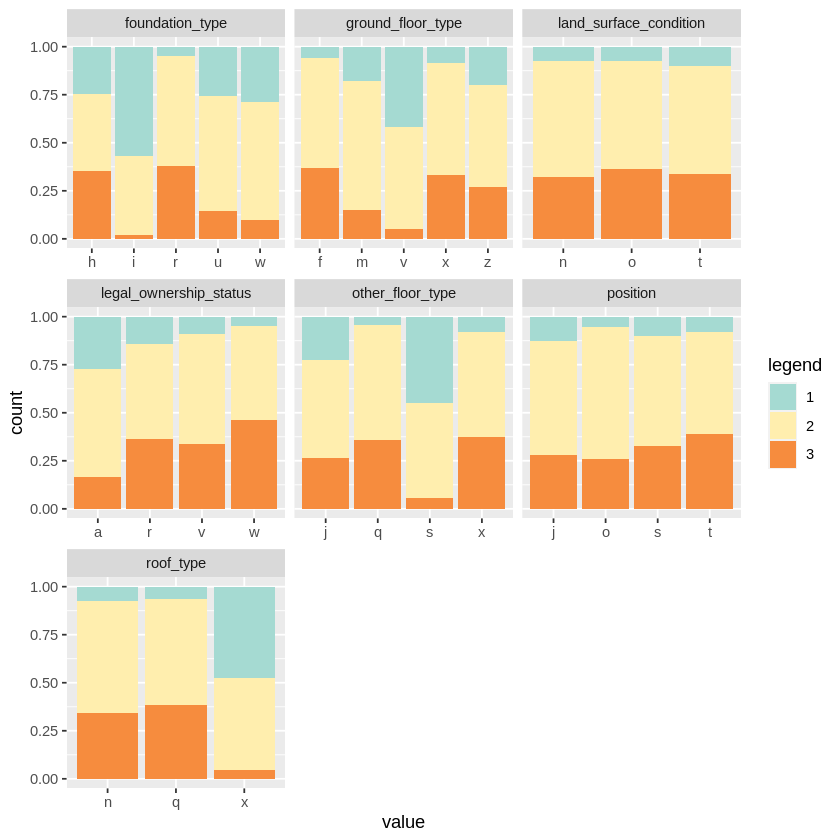

In [8]:
data_char <- data %>% select(land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,legal_ownership_status,damage_grade)
gathered <- data_char %>% gather(variable, value, -damage_grade)
p <- ggplot(gathered, aes(value, fill = factor(damage_grade))) + 
  geom_bar(position = "fill") + facet_wrap( ~ variable, scales = 'free_x') +
  scale_fill_manual("legend", values = c("1" = "#a5dad2", "2" = "#ffeeae", "3" = "#f68c3e"))
p

# ggsave(p, filename = "rest_of_chars.png")

Variables numéricas:

'data.frame':	257113 obs. of  4 variables:
 $ age              : num  25 0 5 80 40 0 0 30 40 5 ...
 $ area_percentage  : num  5 13 12 5 5 6 2 10 5 7 ...
 $ height_percentage: num  2 7 6 4 10 6 6 5 6 6 ...
 $ damage_grade     : Factor w/ 3 levels "1","2","3": 2 3 3 2 2 1 3 3 2 1 ...


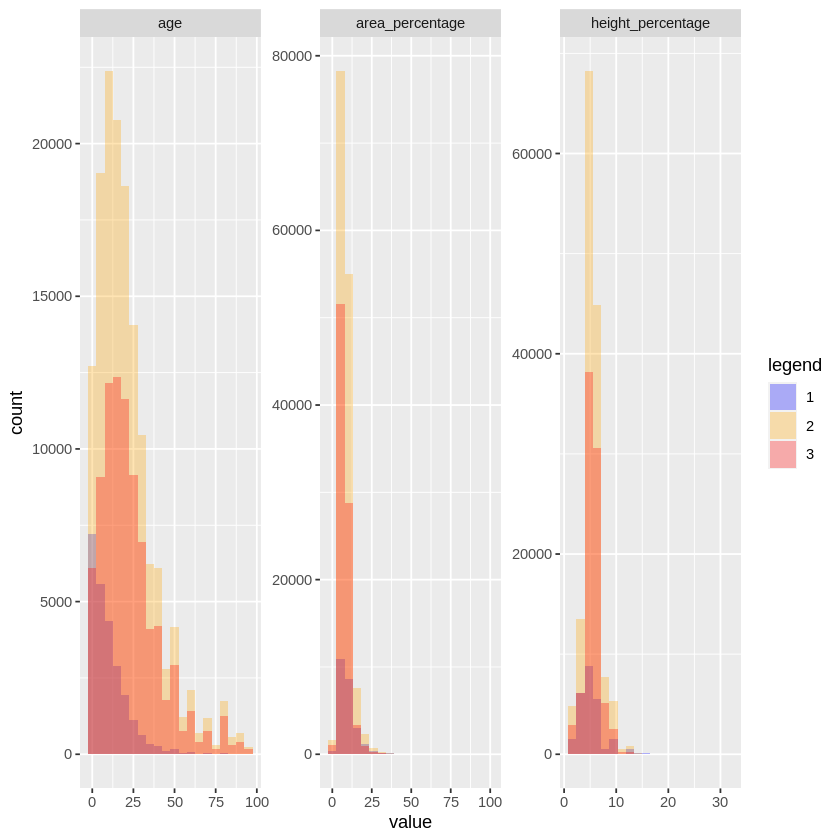

In [9]:
df_rest <- data %>% select(age,area_percentage,height_percentage,damage_grade)
df_rest <- df_rest %>% filter(age<100)
str(df_rest)
gathered <- df_rest %>% gather(variable, value,-damage_grade)
p <- ggplot(gathered, aes(value, fill = factor(damage_grade))) + geom_histogram(bins=20,alpha=0.3, position="identity")+ facet_wrap(~variable, scales = 'free')+
  scale_fill_manual("legend", values = c("1" = "blue", "2" = "orange", "3" = "red"))
p

# ggsave(p, filename = "numeric.png")

## **Kolmogorov-Smirnov**

In [10]:
data_1 <- data %>% filter(damage_grade==1)
data_2 <- data %>% filter(damage_grade==2)
data_3 <- data %>% filter(damage_grade==3)

# age
ks.test(data_1$age,data_2$age)
ks.test(data_1$age,data_3$age)
ks.test(data_2$age,data_3$age)

# area_percentage
ks.test(data_1$area_percentage,data_2$area_percentage)
ks.test(data_1$area_percentage,data_3$area_percentage)
ks.test(data_2$area_percentage,data_3$area_percentage)

# height_percentage
ks.test(data_1$height_percentage,data_2$height_percentage)
ks.test(data_1$height_percentage,data_3$height_percentage)
ks.test(data_2$height_percentage,data_3$height_percentage)

# geo_level_1_id
ks.test(data_1$geo_level_1_id,data_2$geo_level_1_id)
ks.test(data_1$geo_level_1_id,data_3$geo_level_1_id)
ks.test(data_2$geo_level_1_id,data_3$geo_level_1_id)

# geo_level_2_id
ks.test(data_1$geo_level_2_id,data_2$geo_level_2_id)
ks.test(data_1$geo_level_2_id,data_3$geo_level_2_id)
ks.test(data_2$geo_level_2_id,data_3$geo_level_2_id)

# geo_level_3_id
ks.test(data_1$geo_level_3_id,data_2$geo_level_3_id)
ks.test(data_1$geo_level_3_id,data_3$geo_level_3_id)
ks.test(data_2$geo_level_3_id,data_3$geo_level_3_id)

Warning message in ks.test(data_1$age, data_2$age):
“p-value will be approximate in the presence of ties”



	Two-sample Kolmogorov-Smirnov test

data:  data_1$age and data_2$age
D = 0.31809, p-value < 2.2e-16
alternative hypothesis: two-sided


Warning message in ks.test(data_1$age, data_3$age):
“p-value will be approximate in the presence of ties”



	Two-sample Kolmogorov-Smirnov test

data:  data_1$age and data_3$age
D = 0.36955, p-value < 2.2e-16
alternative hypothesis: two-sided


Warning message in ks.test(data_2$age, data_3$age):
“p-value will be approximate in the presence of ties”



	Two-sample Kolmogorov-Smirnov test

data:  data_2$age and data_3$age
D = 0.051462, p-value < 2.2e-16
alternative hypothesis: two-sided


Warning message in ks.test(data_1$area_percentage, data_2$area_percentage):
“p-value will be approximate in the presence of ties”



	Two-sample Kolmogorov-Smirnov test

data:  data_1$area_percentage and data_2$area_percentage
D = 0.14763, p-value < 2.2e-16
alternative hypothesis: two-sided


Warning message in ks.test(data_1$area_percentage, data_3$area_percentage):
“p-value will be approximate in the presence of ties”



	Two-sample Kolmogorov-Smirnov test

data:  data_1$area_percentage and data_3$area_percentage
D = 0.19131, p-value < 2.2e-16
alternative hypothesis: two-sided


Warning message in ks.test(data_2$area_percentage, data_3$area_percentage):
“p-value will be approximate in the presence of ties”



	Two-sample Kolmogorov-Smirnov test

data:  data_2$area_percentage and data_3$area_percentage
D = 0.063867, p-value < 2.2e-16
alternative hypothesis: two-sided


Warning message in ks.test(data_1$height_percentage, data_2$height_percentage):
“p-value will be approximate in the presence of ties”



	Two-sample Kolmogorov-Smirnov test

data:  data_1$height_percentage and data_2$height_percentage
D = 0.17883, p-value < 2.2e-16
alternative hypothesis: two-sided


Warning message in ks.test(data_1$height_percentage, data_3$height_percentage):
“p-value will be approximate in the presence of ties”



	Two-sample Kolmogorov-Smirnov test

data:  data_1$height_percentage and data_3$height_percentage
D = 0.20592, p-value < 2.2e-16
alternative hypothesis: two-sided


Warning message in ks.test(data_2$height_percentage, data_3$height_percentage):
“p-value will be approximate in the presence of ties”



	Two-sample Kolmogorov-Smirnov test

data:  data_2$height_percentage and data_3$height_percentage
D = 0.042445, p-value < 2.2e-16
alternative hypothesis: two-sided


Warning message in ks.test(data_1$geo_level_1_id, data_2$geo_level_1_id):
“p-value will be approximate in the presence of ties”



	Two-sample Kolmogorov-Smirnov test

data:  data_1$geo_level_1_id and data_2$geo_level_1_id
D = 0.22238, p-value < 2.2e-16
alternative hypothesis: two-sided


Warning message in ks.test(data_1$geo_level_1_id, data_3$geo_level_1_id):
“p-value will be approximate in the presence of ties”



	Two-sample Kolmogorov-Smirnov test

data:  data_1$geo_level_1_id and data_3$geo_level_1_id
D = 0.31525, p-value < 2.2e-16
alternative hypothesis: two-sided


Warning message in ks.test(data_2$geo_level_1_id, data_3$geo_level_1_id):
“p-value will be approximate in the presence of ties”



	Two-sample Kolmogorov-Smirnov test

data:  data_2$geo_level_1_id and data_3$geo_level_1_id
D = 0.11762, p-value < 2.2e-16
alternative hypothesis: two-sided


Warning message in ks.test(data_1$geo_level_2_id, data_2$geo_level_2_id):
“p-value will be approximate in the presence of ties”



	Two-sample Kolmogorov-Smirnov test

data:  data_1$geo_level_2_id and data_2$geo_level_2_id
D = 0.086494, p-value < 2.2e-16
alternative hypothesis: two-sided


Warning message in ks.test(data_1$geo_level_2_id, data_3$geo_level_2_id):
“p-value will be approximate in the presence of ties”



	Two-sample Kolmogorov-Smirnov test

data:  data_1$geo_level_2_id and data_3$geo_level_2_id
D = 0.10859, p-value < 2.2e-16
alternative hypothesis: two-sided


Warning message in ks.test(data_2$geo_level_2_id, data_3$geo_level_2_id):
“p-value will be approximate in the presence of ties”



	Two-sample Kolmogorov-Smirnov test

data:  data_2$geo_level_2_id and data_3$geo_level_2_id
D = 0.042449, p-value < 2.2e-16
alternative hypothesis: two-sided


Warning message in ks.test(data_1$geo_level_3_id, data_2$geo_level_3_id):
“p-value will be approximate in the presence of ties”



	Two-sample Kolmogorov-Smirnov test

data:  data_1$geo_level_3_id and data_2$geo_level_3_id
D = 0.022845, p-value = 3.651e-10
alternative hypothesis: two-sided


Warning message in ks.test(data_1$geo_level_3_id, data_3$geo_level_3_id):
“p-value will be approximate in the presence of ties”



	Two-sample Kolmogorov-Smirnov test

data:  data_1$geo_level_3_id and data_3$geo_level_3_id
D = 0.036804, p-value < 2.2e-16
alternative hypothesis: two-sided


Warning message in ks.test(data_2$geo_level_3_id, data_3$geo_level_3_id):
“p-value will be approximate in the presence of ties”



	Two-sample Kolmogorov-Smirnov test

data:  data_2$geo_level_3_id and data_3$geo_level_3_id
D = 0.019634, p-value < 2.2e-16
alternative hypothesis: two-sided


## **Variables categóricas**

In [11]:
is_categorical_var <- sapply(train_values, is.factor)
cat_vars <- train_values[, is_categorical_var]

names(cat_vars)

[1] "land_surface_condition" "foundation_type"        "roof_type"             
[4] "ground_floor_type"      "other_floor_type"       "position"              
[7] "plan_configuration"     "legal_ownership_status"

Evaluación de las categorías:

In [12]:
difference <- function(x,thr=0.3){
  frequencies <- as.data.frame.matrix(table(data %>% select(all_of(x),damage_grade) %>% group_by(damage_grade)))
  percentage <- cbind(frequencies,sum=rowSums(frequencies))
  percentage <- percentage/percentage$sum
  labels <- rownames(percentage)
  print(labels)
  pairs <- Pair(labels, labels)
  for (i_index in 1:length(labels)){
    for (j_index in i_index:length(labels)){
      i <- pairs[i_index,1]
      j <- pairs[j_index,2]
      if (all(abs(percentage[i,]-percentage[j,])/(percentage[i,]+percentage[j,])<thr)&&(i!=j)){
        cat("Las etiquetas",i,"y",j,"son iguales con un error relativo de",thr,"\n")
      }
    }
  }
}

difference("foundation_type")
difference("ground_floor_type")
difference("plan_configuration")
difference("roof_type")
difference("other_floor_type")
difference("land_surface_condition")
difference("legal_ownership_status")
difference("position")

# remove: land_surface_condition, position

difference("has_superstructure_adobe_mud",0.5)
difference("has_superstructure_mud_mortar_stone",0.5)
difference("has_superstructure_stone_flag",0.5)
difference("has_superstructure_cement_mortar_stone",0.5)
difference("has_superstructure_mud_mortar_brick",0.5)
difference("has_superstructure_cement_mortar_brick",0.5)
difference("has_superstructure_timber",0.5)
difference("has_superstructure_bamboo",0.5)
difference("has_superstructure_rc_non_engineered",0.5)
difference("has_superstructure_rc_engineered",0.5)
difference("has_superstructure_other",0.5)

# with thr= 0.3 remove: has_superstructure_timber,has_superstructure_bamboo,has_superstructure_other
# with thr= 0.5 remove: has_superstructure_timber,has_superstructure_bamboo,has_superstructure_other,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick

difference("has_secondary_use",0.5)
difference("has_secondary_use_agriculture",0.5)
difference("has_secondary_use_hotel",0.5)
difference("has_secondary_use_rental",0.5)
difference("has_secondary_use_institution",0.5)
difference("has_secondary_use_school",0.5)
difference("has_secondary_use_industry",0.5)
difference("has_secondary_use_health_post",0.5)
difference("has_secondary_use_gov_office",0.5)
difference("has_secondary_use_use_police",0.5)
difference("has_secondary_use_other",0.5)


# with thr= 0.3 remove: has_secondary_use, has_secondary_use_use_police, has_secondary_use_other
# with thr= 0.5 remove: has_secondary_use, has_secondary_use_use_police, has_secondary_use_other,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_industry

[1] "h" "i" "r" "u" "w"
Las etiquetas u y w son iguales con un error relativo de 0.3 
[1] "f" "m" "v" "x" "z"
Las etiquetas f y x son iguales con un error relativo de 0.3 
Las etiquetas m y z son iguales con un error relativo de 0.3 
 [1] "a" "c" "d" "f" "m" "n" "o" "q" "s" "u"
Las etiquetas a y c son iguales con un error relativo de 0.3 
Las etiquetas a y m son iguales con un error relativo de 0.3 
Las etiquetas a y o son iguales con un error relativo de 0.3 
Las etiquetas a y s son iguales con un error relativo de 0.3 
Las etiquetas a y u son iguales con un error relativo de 0.3 
Las etiquetas c y m son iguales con un error relativo de 0.3 
Las etiquetas c y o son iguales con un error relativo de 0.3 
Las etiquetas c y u son iguales con un error relativo de 0.3 
Las etiquetas d y n son iguales con un error relativo de 0.3 
Las etiquetas d y q son iguales con un error relativo de 0.3 
Las etiquetas d y s son iguales con un error relativo de 0.3 
Las etiquetas m y o son iguales con un 

Más análisis de superstructure y secondary use:

In [13]:
group_superstructure <- function(data) {
  data <- data %>% mutate(superstructure = 
                            ifelse(has_superstructure_adobe_mud == 1 | has_superstructure_mud_mortar_brick == 1 |
                                     has_superstructure_mud_mortar_stone == 1 | has_superstructure_stone_flag == 1, "non-robust", "robust")
  )

  data$superstructure <- as.factor(data$superstructure)
  data <- data %>% select(-starts_with('has_superstructure'))
    
}

data <- group_superstructure(data)

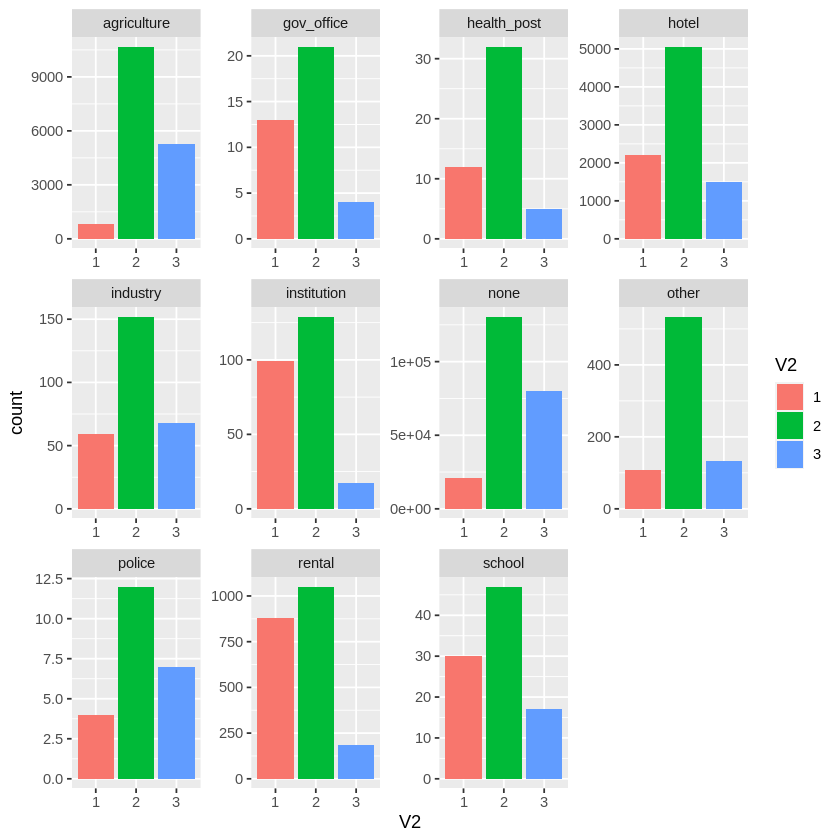

In [14]:
secondary <- data %>% select(starts_with('has_secondary'))
secondary <- secondary %>%
  mutate(secondary =
      ifelse(has_secondary_use == 0, 'none',
      ifelse(has_secondary_use_agriculture == 1, 'agriculture',
      ifelse(has_secondary_use_hotel == 1, 'hotel',
      ifelse(has_secondary_use_rental == 1, 'rental',
      ifelse(has_secondary_use_institution == 1, 'institution',
      ifelse(has_secondary_use_gov_office == 1, 'gov_office',
      ifelse(has_secondary_use_school == 1, 'school',
      ifelse(has_secondary_use_industry == 1, 'industry',
      ifelse(has_secondary_use_health_post == 1, 'health_post',
      ifelse(has_secondary_use_use_police == 1, 'police', 'other')))))))))))


secondary <- secondary$secondary
secondary <- cbind(secondary, data$damage_grade)
secondary <- as.data.frame(secondary)

ggplot(secondary, aes(V2, fill = V2)) + geom_bar() + facet_wrap(~ secondary, scales = "free") 

Nueva distribución de superstructure y secondary use risk:

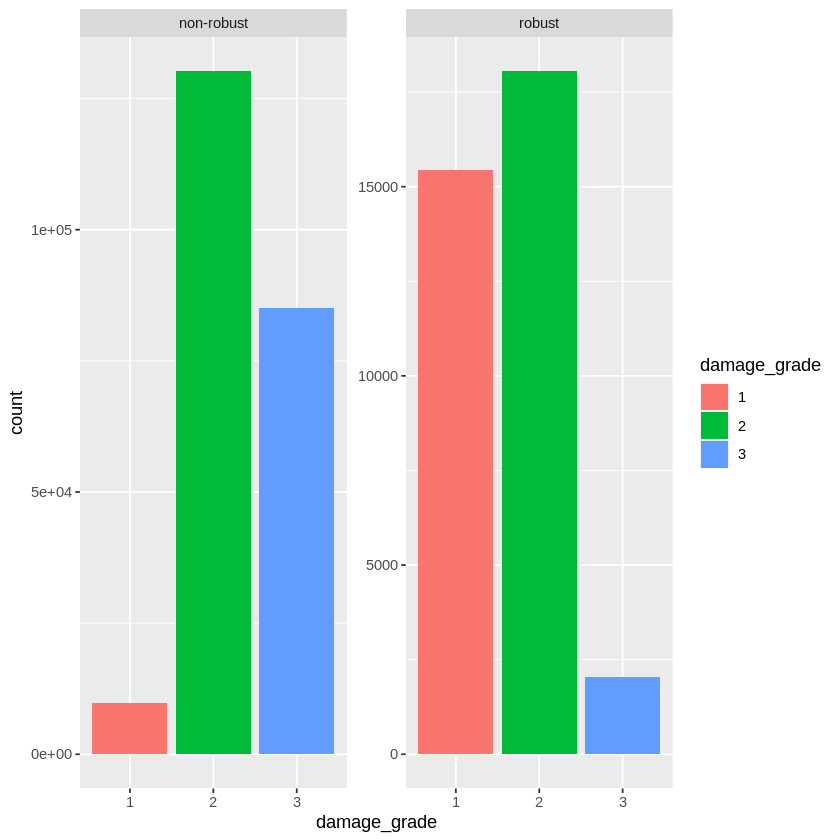

In [20]:
ggplot(data, aes(damage_grade, fill=damage_grade)) + geom_bar() + facet_wrap(~superstructure, scales="free") 

## **Detección de ruido**

In [16]:
out_noise <- IPF(damage_grade ~ ., data)
out_noise

data_clean <- out_noise$cleanData

table(data_clean$damage_grade)

Iteration 1: 41111 noisy instances removed 


Iteration 2: 16477 noisy instances removed 


Iteration 3: 8993 noisy instances removed 


Iteration 4: 5154 noisy instances removed 


Iteration 5: 3423 noisy instances removed 


Iteration 6: 2297 noisy instances removed 


Iteration 7: 1749 noisy instances removed 


Iteration 8: 1255 noisy instances removed 




Call:
IPF(formula = damage_grade ~ ., data = data)

Parameters:
nfolds: 5
consensus: FALSE
p: 0.01
s: 3
y: 0.5

Results:
Number of removed instances: 80459 (30.8744 %)
Number of repaired instances: 0 (0 %)


     1      2      3 
  7992 125431  46719 

## **Variables numéricas**

In [17]:
is_numeric_var <- sapply(train_values, is.numeric)
num_vars <- train_values[, is_numeric_var]

names(num_vars)

[1] "building_id"                           
 [2] "geo_level_1_id"                        
 [3] "geo_level_2_id"                        
 [4] "geo_level_3_id"                        
 [5] "count_floors_pre_eq"                   
 [6] "age"                                   
 [7] "area_percentage"                       
 [8] "height_percentage"                     
 [9] "has_superstructure_adobe_mud"          
[10] "has_superstructure_mud_mortar_stone"   
[11] "has_superstructure_stone_flag"         
[12] "has_superstructure_cement_mortar_stone"
[13] "has_superstructure_mud_mortar_brick"   
[14] "has_superstructure_cement_mortar_brick"
[15] "has_superstructure_timber"             
[16] "has_superstructure_bamboo"             
[17] "has_superstructure_rc_non_engineered"  
[18] "has_superstructure_rc_engineered"      
[19] "has_superstructure_other"              
[20] "count_families"                        
[21] "has_secondary_use"                     
[22] "has_secondary_use_agriculture"         
[23] "has_secondary_use_hotel"               
[24] "has_secondary_use_rental"              
[25] "has_secondary_use_institution"         
[26] "has_secondary_use_school"              
[27] "has_secondary_use_industry"            
[28] "has_secondary_use_health_post"         
[29] "has_secondary_use_gov_office"          
[30] "has_secondary_use_use_police"          
[31] "has_secondary_use_other"

Test de normalidad de Anderson-Darling:

In [18]:
sapply(train_values[, is_numeric_var], ad.test)

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,⋯,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,⋯,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>
statistic,2936.713,6551.497,2868.178,3041.811,24136.12,56099.72,10890.86,5705.85,87793.87,64080.9,⋯,91842.29,96580.8,99887.8,100596.4,100642.5,100585.6,100655.4,100658.5,100662.6,100204.5
p.value,3.7e-24,3.7e-24,3.7e-24,3.7e-24,3.7e-24,3.7e-24,3.7e-24,3.7e-24,3.7e-24,3.7e-24,⋯,3.7e-24,3.7e-24,3.7e-24,3.7e-24,3.7e-24,3.7e-24,3.7e-24,3.7e-24,3.7e-24,3.7e-24
method,Anderson-Darling normality test,Anderson-Darling normality test,Anderson-Darling normality test,Anderson-Darling normality test,Anderson-Darling normality test,Anderson-Darling normality test,Anderson-Darling normality test,Anderson-Darling normality test,Anderson-Darling normality test,Anderson-Darling normality test,⋯,Anderson-Darling normality test,Anderson-Darling normality test,Anderson-Darling normality test,Anderson-Darling normality test,Anderson-Darling normality test,Anderson-Darling normality test,Anderson-Darling normality test,Anderson-Darling normality test,Anderson-Darling normality test,Anderson-Darling normality test
data.name,X[[i]],X[[i]],X[[i]],X[[i]],X[[i]],X[[i]],X[[i]],X[[i]],X[[i]],X[[i]],⋯,X[[i]],X[[i]],X[[i]],X[[i]],X[[i]],X[[i]],X[[i]],X[[i]],X[[i]],X[[i]]
